## Hands-on Tutorial: Quantifying and Reducing Gender Stereotypes in Word Embeddings

Ensuring fairness in algorithmically-driven decision-making is important to avoid inadvertent cases of bias and perpetuation of harmful stereotypes. However, modern natural language processing techniques, which learn model parameters based on data, might rely on implicit biases presented in the data to make undesirable stereotypical associations. Such a danger is facing us with word embedding, a popular framework to represent text data as vectors which has been used in many machine learning and natural language processing tasks. Recent results ([1](https://arxiv.org/abs/1607.06520), [2](https://arxiv.org/abs/1608.07187)) show that even word embeddings trained on Google News articles exhibit female/male gender stereotypes to a disturbing extent. This raises concerns because of their widespread use, as we describe, often tends to amplify these biases. 

In the following, we provide step-by-step instructions to demonstrate and quanitfy the biases in word embedding.



In [1]:
# Setup:
# Clone the code repository from https://github.com/tolga-b/debiaswe.git
# mkdir debiaswe_tutorial
# cd debiaswe_tutorial
# git clone https://github.com/tolga-b/debiaswe.git

# To reduce the time of downloading data, we provide as subset of GoogleNews-vectors in the following location:
# https://drive.google.com/file/d/1NH6jcrg8SXbnhpIXRIXF_-KUE7wGxGaG/view?usp=sharing

# For full embeddings:
# Download embeddings at https://github.com/tolga-b/debiaswe and put them on the following directory
# embeddings/GoogleNews-vectors-negative300-hard-debiased.bin
# embeddings/GoogleNews-vectors-negative300.bin

In [2]:
from __future__ import print_function, division
%matplotlib inline
from matplotlib import pyplot as plt
import json
import random
import numpy as np

import debiaswe as dwe
import debiaswe.we as we
from debiaswe.we import WordEmbedding
from debiaswe.data import *

## Part 1: Gender Bias in Word Embedding


### Step 1: Load data
We first load the word embedding trained on a corpus of Google News texts consisting of 3 million English words and terms. The embedding maps each word into a 300-dimension vector. 

In [3]:
# load google news word2vec
E = WordEmbedding('./embeddings/w2v_gnews_small.txt')
# E = WordEmbedding('./embeddings/GoogleNews-vectors-negative300.bin')

# load data
profession_words, defs, equalize_pairs = load_data()

Creating embedding from file: C:\Users\kylia\Documents\Msc AI jaar 1\FACTAI\FactAI\replication\embeddings\w2v_gnews_small.txt
26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine
Embedding shape: (26423, 300)


1.0
-0.00095485727


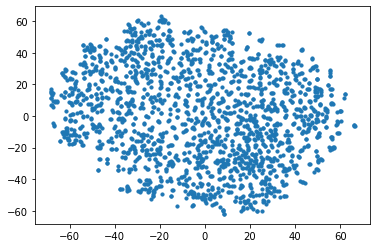

In [4]:
# Extra test cell, remove later
print(np.linalg.norm(E.vecs, axis=1).mean())
print(E.vecs.mean())

from sklearn.manifold import TSNE
tsne = TSNE(n_components=2).fit_transform(E.vecs[:2000])
plt.scatter(tsne[:,0], tsne[:,1], s=10)
plt.show()

### Step 2: Define gender direction

We define gender direction by the direciton of she - he because they are frequent and do not have fewer alternative word senses (e.g., man can also refer to mankind). In the paper, we discuss alternative approach for defining gender direction (e.g., using PCA).

In [5]:
# gender direction
# v_gender = E.diff('she', 'he')

v_gender = we.doPCA(defs, E).components_[0]

### Step 3: Generating analogies of "Man: x :: Woman : y"

We show that the word embedding model generates gender-streotypical analogy pairs. 
To generate the analogy pairs, we use the analogy score defined in our paper. This score finds word pairs that are well aligned with gender direction as well as within a short distance from each other to preserve topic consistency. 


In [6]:
# analogies gender
a_gender = E.best_analogies_dist_thresh(v_gender, thresh=1)

we.viz(a_gender)

Computing neighbors
Mean: 10.219732808538016
Median: 7.0
(135018, 300)
   0                      herself | himself                      0.94
   1                          she | he                           0.94
   2                          her | his                          0.91
   3                        woman | man                          0.82
   4                     daughter | son                          0.74
   5                         girl | boy                          0.74
   6                      actress | actor                        0.72
   7                businesswoman | businessman                  0.70
   8                       sister | brother                      0.69
   9                       mother | father                       0.69
  10                  spokeswoman | spokesman                    0.67
  11                      heroine | hero                         0.67
  12                   chairwoman | chairman                     0.67
  13               

### Step 4: Analyzing gender bias in word vectors asscoiated with professions

Next, we show that many occupations are unintendedly associated with either male of female by projecting their word vectors onto the gender dimension. 

The script will output the profession words sorted with respect to the projection score in the direction of gender.

In [7]:
# profession analysis gender
sp = E.profession_stereotypes(profession_words, v_gender)

                Female                |                 Male                 
-----------------------------------------------------------------------------
0.38                    businesswoman | maestro                        -0.244
0.379                         actress | protege                        -0.236
0.378                       housewife | statesman                      -0.222
0.323                       homemaker | businessman                    -0.219
0.308                           nurse | sportsman                      -0.209
0.302                registered_nurse | philosopher                    -0.196
0.297                        waitress | marksman                       -0.192
0.28                     receptionist | skipper                        -0.187
0.278                       socialite | financier                      -0.183
0.277                       librarian | architect                      -0.177
0.272                            maid | magician                

## Part 2 Racial Bias

### Step 5: Define racial direction
We define racial direction based on the common names in different Demographic groups. 

In [8]:
names = ["Emily", "Aisha", "Anne", "Keisha", "Jill", "Tamika", "Allison", "Lakisha", "Laurie", "Tanisha", "Sarah",
         "Latoya", "Meredith", "Kenya", "Carrie", "Latonya", "Kristen", "Ebony", "Todd", "Rasheed", "Neil", "Tremayne",
         "Geoffrey", "Kareem", "Brett", "Darnell", "Brendan", "Tyrone", "Greg", "Hakim", "Matthew", "Jamal", "Jay",
         "Leroy", "Brad", "Jermaine"]
names_group1 = [names[2 * i] for i in range(len(names) // 2)]
names_group2 = [names[2 * i + 1] for i in range(len(names) // 2)]

In [9]:
# racial direction
vs = [sum(E.v(w) for w in names) for names in (names_group2, names_group1)]
vs = [v / np.linalg.norm(v) for v in vs]

v_racial = vs[1] - vs[0]
v_racial = v_racial / np.linalg.norm(v_racial)

### Step 6: Generating racial biased analogies

Similar to Step 3, we generate analogies that align with the racial dimension. 

In [10]:
# racial analogies
a_racial = E.best_analogies_dist_thresh(v_racial)
we.viz(a_racial)

   0                        Sarah | Keisha                       0.67
   1                   defensemen | cornerbacks                  0.37
   2                      hipster | hip_hop                      0.35
   3                       punter | cornerback                   0.35
   4            singer_songwriter | rapper                       0.34
   5                   defenseman | defensive_tackle             0.34
   6                   pole_vault | triple_jump                  0.33
   7                    musicians | artistes                     0.32
   8                     musician | artiste                      0.32
   9                      catcher | wide_receiver                0.31
  10                  rock_n_roll | reggae                       0.30
  11                       kicker | kick_returner                0.30
  12                       tavern | barbershop                   0.30
  13              freestyle_relay | meter_hurdles                0.30
  14                

### Step 7: Analyzing racial bias in word vectors asscoiated with professions

Similar to Step 4, we project occpurations onto the racial dimension.

In [11]:
# profession analysis racial
sp = sorted([(E.v(w).dot(v_racial), w) for w in profession_words])

sp[0:20], sp[-20:]

([(-0.3154624, 'artiste'),
  (-0.27369624, 'shopkeeper'),
  (-0.27285585, 'taxi_driver'),
  (-0.24248752, 'cab_driver'),
  (-0.230962, 'preacher'),
  (-0.21709058, 'boxer'),
  (-0.20973533, 'laborer'),
  (-0.20361684, 'barber'),
  (-0.19625023, 'cleric'),
  (-0.182731, 'bodyguard'),
  (-0.18250425, 'gangster'),
  (-0.1816296, 'singer'),
  (-0.16877083, 'maid'),
  (-0.16871038, 'entertainer'),
  (-0.16197538, 'cabbie'),
  (-0.15332887, 'housewife'),
  (-0.14839593, 'civil_servant'),
  (-0.14115773, 'policeman'),
  (-0.13648951, 'minister'),
  (-0.1329656, 'drug_addict')],
 [(0.087792546, 'organist'),
  (0.09007451, 'philanthropist'),
  (0.09135293, 'cinematographer'),
  (0.093180254, 'manager'),
  (0.09358391, 'investment_banker'),
  (0.096878394, 'professor_emeritus'),
  (0.097828984, 'curator'),
  (0.09864862, 'freelance_writer'),
  (0.09917156, 'programmer'),
  (0.10142014, 'screenwriter'),
  (0.10198846, 'author'),
  (0.10438656, 'inventor'),
  (0.106778406, 'adventurer'),
  (0.1096

## Exercise

Repeat Step 2-4 with debiased word embedding. 

You can use debiaswe debias function to do the debiasing with word sets of your choosing

You can leave equalize_pairs and gender_specific_words blank when coming up with your own groups. We give an example for the case of gender below for you to warm up.

In [14]:
from debiaswe.debias import hard_debias

hard_debias(E, gender_specific_words, defs, equalize_pairs)

26423 words of dimension 300 : in, for, that, is, ..., Jay, Leroy, Brad, Jermaine
{('BROTHER', 'SISTER'), ('EX_GIRLFRIEND', 'EX_BOYFRIEND'), ('BOY', 'GIRL'), ('Men', 'Women'), ('Wives', 'Husbands'), ('MALES', 'FEMALES'), ('dad', 'mom'), ('Himself', 'Herself'), ('son', 'daughter'), ('man', 'woman'), ('Spokesman', 'Spokeswoman'), ('Gentlemen', 'Ladies'), ('KINGS', 'QUEENS'), ('KING', 'QUEEN'), ('Twin_Brother', 'Twin_Sister'), ('councilman', 'councilwoman'), ('GRANDPA', 'GRANDMA'), ('Businessman', 'Businesswoman'), ('grandfather', 'grandmother'), ('Fella', 'Granny'), ('Grandpa', 'Grandma'), ('SON', 'DAUGHTER'), ('Councilman', 'Councilwoman'), ('MALE', 'FEMALE'), ('FATHERHOOD', 'MOTHERHOOD'), ('Dad', 'Mom'), ('men', 'women'), ('FRATERNITY', 'SORORITY'), ('Brother', 'Sister'), ('Congressman', 'Congresswoman'), ('Schoolboy', 'Schoolgirl'), ('Monastery', 'Convent'), ('dads', 'moms'), ('Ex_Girlfriend', 'Ex_Boyfriend'), ('Fathers', 'Mothers'), ('COUNCILMAN', 'COUNCILWOMAN'), ('Grandson', 'Grand

In [15]:
# save hard-debiased embeddings

E.save('./embeddings/w2v_gnews_small_hard_debiased.txt')
# E.save('./embeddings/GoogleNews-vectors-negative300_hard_debiased.bin')

Wrote 26423 words to ./embeddings/w2v_gnews_small_hard_debiased.txt


In [16]:
# profession analysis gender
sp_debiased = sorted([(E.v(w).dot(v_gender), w) for w in profession_words])

sp_debiased[0:20], sp_debiased[-20:]

([(-0.4332522, 'businessman'),
  (-0.42799938, 'congressman'),
  (-0.3652529, 'dad'),
  (-0.35791722, 'councilman'),
  (-0.22225755, 'statesman'),
  (-0.15711337, 'salesman'),
  (-0.10675365, 'handyman'),
  (-0.08172014, 'monk'),
  (-6.7055225e-08, 'skipper'),
  (-5.2154064e-08, 'jeweler'),
  (-4.0512532e-08, 'comedian'),
  (-3.7252903e-08, 'restaurateur'),
  (-3.3527613e-08, 'architect'),
  (-3.0733645e-08, 'promoter'),
  (-2.9802322e-08, 'cameraman'),
  (-2.9802322e-08, 'inventor'),
  (-2.9802322e-08, 'sportsman'),
  (-2.8871e-08, 'economics_professor'),
  (-2.7939677e-08, 'strategist'),
  (-2.6542693e-08, 'captain')],
 [(2.9802322e-08, 'vocalist'),
  (3.0267984e-08, 'superintendent'),
  (3.0733645e-08, 'warden'),
  (3.1664968e-08, 'bookkeeper'),
  (3.1664968e-08, 'provost'),
  (3.3527613e-08, 'pathologist'),
  (3.3993274e-08, 'paralegal'),
  (3.7252903e-08, 'correspondent'),
  (3.7718564e-08, 'fisherman'),
  (3.9115548e-08, 'lecturer'),
  (4.5634806e-08, 'homemaker'),
  (4.8428774e-

In [17]:
# analogies gender
a_gender_debiased = E.best_analogies_dist_thresh(v_gender)
we.viz(a_gender_debiased)

# for (a,b,c) in a_gender_debiased:
#     print(a+"-"+b)
we.viz(a_gender_debiased)

Computing neighbors
Mean: 10.218597434053665
Median: 7.0
(135003, 300)
   0                 ex_boyfriend | ex_girlfriend                1.0
   1                businesswoman | businessman                  1.0
   2                      grandma | grandpa                      1.0
   3                    daughters | sons                         1.0
   4                        girls | boys                         1.0
   5                congresswoman | congressman                  1.0
   6                       female | male                         1.0
   7                       mother | father                       1.0
   8                         gals | dudes                        1.0
   9                   schoolgirl | schoolboy                    1.0
  10                         mare | gelding                      1.0
  11                         aunt | uncle                        1.0
  12                     husbands | wives                        1.0
  13                  spokeswoma